# Automation by using long candidates

In [1]:
# Library
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.ensemble import RandomForestRegressor
from transformers import AutoTokenizer, AutoModelForCausalLM
import automation

from sdscm import plot_dag_from_sample_space, sample_sequences, format_sequences_as_dataframe, sample_counterfactual_sequences

In [2]:
# Original llm
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-1.7B')
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained('Qwen/Qwen3-1.7B')
model.config.pad_token_id = model.config.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:

# 读取数据
df = pd.read_csv("Titanic-Dataset.csv")

to_drop = []
row_count = len(df)

# 删除高基数列或唯一列
for col in df.columns:
    nunique = df[col].nunique(dropna=True)
    unique_ratio = nunique / row_count

    if (not pd.api.types.is_numeric_dtype(df[col]) and nunique > 10) or (unique_ratio == 1.0):
        to_drop.append(col)

df_filtered = df.drop(columns=to_drop)

# ====== 新增部分：自动填充缺失值 ======
for col in df_filtered.columns:
    if pd.api.types.is_numeric_dtype(df_filtered[col]):
        # 数值列：用中位数填充
        median_val = df_filtered[col].median()
        df_filtered[col] = df_filtered[col].fillna(median_val)
    else:
        # 类别或字符串列：用众数（出现频率最高的值）填充
        mode_val = df_filtered[col].mode(dropna=True)
        if not mode_val.empty:
            df_filtered[col] = df_filtered[col].fillna(mode_val[0])
        else:
            df_filtered[col] = df_filtered[col].fillna("Unknown")

# ====== 输出结果 ======
print(f"Deleted {len(to_drop)} variables:", to_drop)
print(f"DataFrame shape after filtering & filling: {df_filtered.shape}")
print("\nData summary after filling:")
print(df_filtered.describe(include='all'))


Deleted 4 variables: ['PassengerId', 'Name', 'Ticket', 'Cabin']
DataFrame shape after filtering & filling: (891, 8)

Data summary after filling:
          Survived      Pclass   Sex         Age       SibSp       Parch  \
count   891.000000  891.000000   891  891.000000  891.000000  891.000000   
unique         NaN         NaN     2         NaN         NaN         NaN   
top            NaN         NaN  male         NaN         NaN         NaN   
freq           NaN         NaN   577         NaN         NaN         NaN   
mean      0.383838    2.308642   NaN   29.361582    0.523008    0.381594   
std       0.486592    0.836071   NaN   13.019697    1.102743    0.806057   
min       0.000000    1.000000   NaN    0.420000    0.000000    0.000000   
25%       0.000000    2.000000   NaN   22.000000    0.000000    0.000000   
50%       0.000000    3.000000   NaN   28.000000    0.000000    0.000000   
75%       1.000000    3.000000   NaN   35.000000    1.000000    0.000000   
max       1.000000 

In [4]:
new_df = automation.discrete_candidates(df_filtered)
print(new_df)

     Survived  Pclass     Sex  SibSp  Parch Embarked Age_3class Fare_3class
0           0       3    male      1      0        S    Age_low    Fare_low
1           1       1  female      1      0        C   Age_high   Fare_high
2           1       3  female      0      0        S    Age_mid    Fare_low
3           1       1  female      1      0        S   Age_high   Fare_high
4           0       3    male      0      0        S   Age_high    Fare_low
..        ...     ...     ...    ...    ...      ...        ...         ...
886         0       2    male      0      0        S    Age_mid    Fare_mid
887         1       1  female      0      0        S    Age_low   Fare_high
888         0       3  female      1      2        S    Age_mid    Fare_mid
889         1       1    male      0      0        C    Age_mid   Fare_high
890         0       3    male      0      0        Q   Age_high    Fare_low

[891 rows x 8 columns]


In [5]:
#New dataset with discrete candidatews
description= """
This dataset contains detailed information about passengers aboard the Titanic, capturing both demographic and socio-economic characteristics. Each record represents one passenger, including whether they survived the disaster (Survived), their ticket class (Pclass), gender (Sex), and the number of siblings or spouses (SibSp) and parents or children (Parch) aboard.
The Embarked variable indicates the port of boarding: Cherbourg (C), Queenstown (Q), or Southampton (S). In addition, continuous variables such as Age and Fare have been transformed into three discrete levels (low, mid, high) to represent relative categories of age and ticket price among passengers.
"""
candidates_set = automation.build_long_candidates_set(tokenizer,model,new_df,description=description)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Added column: Survived (2 sentences)
✅ Added column: Pclass (3 sentences)
✅ Added column: Sex (2 sentences)
✅ Added column: SibSp (7 sentences)
✅ Added column: Parch (7 sentences)
✅ Added column: Embarked (3 sentences)
✅ Added column: Age_3class (3 sentences)
✅ Added column: Fare_3class (3 sentences)


In [6]:
for i in candidates_set.keys():
    print(f"{i}: {candidates_set[i]}\n")

Survived: ["The passenger's survival status is recorded as 0.", 'The passenger survived the disaster.']

Pclass: ['The passenger is in the third class.', 'The passenger is in first class.', 'The passenger is in the second class.']

Sex: ['The passenger is male.', 'The passenger is female.']

SibSp: ['The passenger has 1 sibling or spouse aboard.', 'The passenger has 0 siblings or spouses aboard the Titanic.', 'The passenger has 3 siblings or spouses aboard the Titanic.', 'The passenger has 4 siblings or spouses aboard the Titanic.', 'The passenger has 2 siblings or spouses aboard.', 'The passenger has 5 siblings or spouses aboard the Titanic.', 'The passenger has 8 siblings or spouses aboard the Titanic.']

Parch: ['The passenger has 0 siblings or spouses aboard.', 'The passenger has 1 sibling or spouse aboard.', 'The passenger has 2 siblings or spouses aboard.', 'The passenger has 5 siblings or spouses aboard.', 'The passenger has 3 siblings or spouses aboard.', 'The passenger has 4 s

In [7]:
print(candidates_set)

{'Survived': ["The passenger's survival status is recorded as 0.", 'The passenger survived the disaster.'], 'Pclass': ['The passenger is in the third class.', 'The passenger is in first class.', 'The passenger is in the second class.'], 'Sex': ['The passenger is male.', 'The passenger is female.'], 'SibSp': ['The passenger has 1 sibling or spouse aboard.', 'The passenger has 0 siblings or spouses aboard the Titanic.', 'The passenger has 3 siblings or spouses aboard the Titanic.', 'The passenger has 4 siblings or spouses aboard the Titanic.', 'The passenger has 2 siblings or spouses aboard.', 'The passenger has 5 siblings or spouses aboard the Titanic.', 'The passenger has 8 siblings or spouses aboard the Titanic.'], 'Parch': ['The passenger has 0 siblings or spouses aboard.', 'The passenger has 1 sibling or spouse aboard.', 'The passenger has 2 siblings or spouses aboard.', 'The passenger has 5 siblings or spouses aboard.', 'The passenger has 3 siblings or spouses aboard.', 'The passen

In [8]:
filled_config = automation.fill_candidate_sets(
    'titanic_framework.json',  
    candidates_set,            
    'titanic_ready.json'       
)

Filled Sex: 2 candidates
Filled Age_3class: 3 candidates
Filled Pclass: 3 candidates
Filled Embarked: 3 candidates
Filled Fare_3class: 3 candidates
Filled SibSp: 7 candidates
Filled Parch: 7 candidates
Filled Survived: 2 candidates
Updated intervention_choices for Sex: [0, 1]
Updated possible_outcome_choices for Survived: [0, 1]

Filled configuration saved to titanic_ready.json


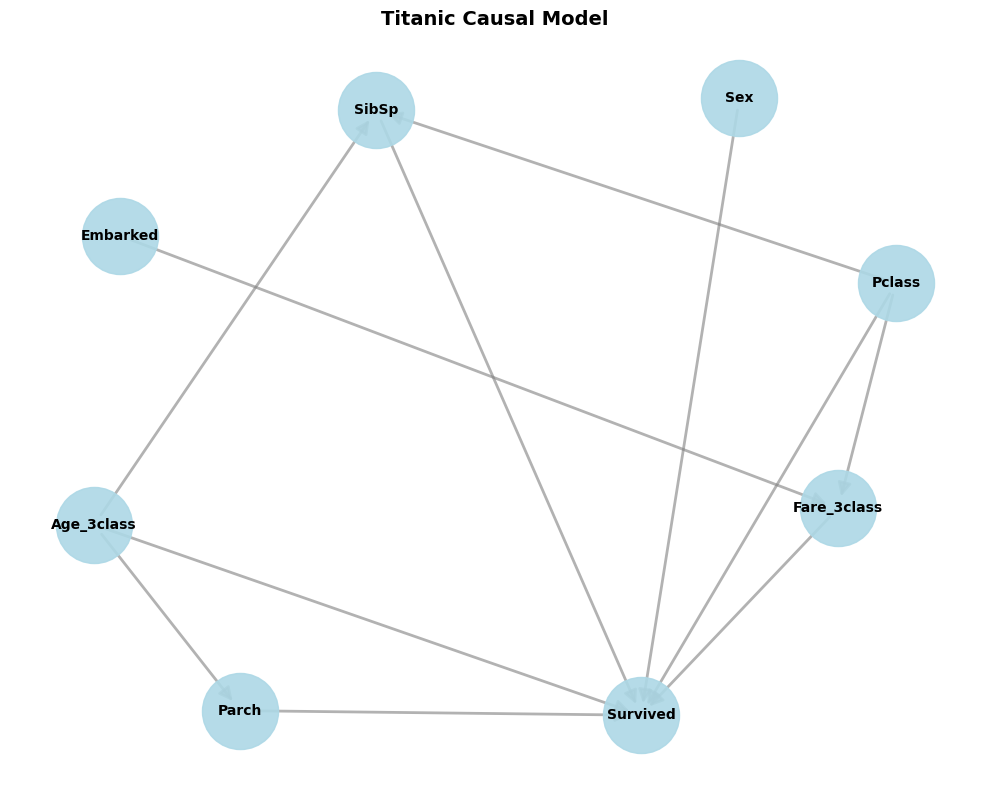

In [9]:
plot_dag_from_sample_space(
    filled_config['setup_sequence_sample_space'],
    title='Titanic Causal Model'
)


In [10]:
# import new_sdscm_2
# # import importlib
# # importlib.reload(new_sdscm_2)
# results = new_sdscm_2.generate_counterfactual_datasets(
#     model, tokenizer, filled_config,
#     num_samples=100
# )

# analysis = new_sdscm_2.comprehensive_distribution_analysis(results)

In [11]:
import new_sdscm

ate = new_sdscm.calculate_ate(model, tokenizer, filled_config,num_samples =100)

0it [00:00, ?it/s]


TypeError: 'int' object is not iterable

In [ ]:
#From dataset
p_survived_sex0 = df.loc[df['Sex'] == "male", 'Survived'].mean()
p_survived_sex1 = df.loc[df['Sex'] == "female", 'Survived'].mean()


ate = p_survived_sex1 - p_survived_sex0

print("=== Average Treatment Effect ===")
print("Intervention: Sex")
print("Outcome: Survived")
print(f"P(Survived=1 | do(Sex=0)): {p_survived_sex0:.3f}")
print(f"P(Survived=1 | do(Sex=1)): {p_survived_sex1:.3f}")
print(f"ATE: {ate:.3f}")


=== Average Treatment Effect ===
Intervention: Sex
Outcome: Survived
P(Survived=1 | do(Sex=0)): 0.189
P(Survived=1 | do(Sex=1)): 0.742
ATE: 0.553


In [ ]:
ate = new_sdscm.calculate_ate(model, tokenizer, filled_config,num_samples =500)

100%|██████████| 500/500 [54:57<00:00,  6.60s/it]


=== Average Treatment Effect ===
Intervention: Sex
Outcome: Survived
P(Survived=1 | do(Sex=0)): 0.548
P(Survived=1 | do(Sex=1)): 0.504
ATE: -0.044


In [19]:
#code for multiple candidate sets with different sentence lengths.
import re
def build_multiple_length_candidates(
    tokenizer,
    model,
    df,
    description=None,
    length_configs=None,
    deterministic=True
):
    """
    Generate multiple candidate sets with different sentence lengths.
    
    Args:
        tokenizer: HuggingFace tokenizer
        model: HuggingFace model
        df (pd.DataFrame): Input dataset
        description (str, optional): Dataset description
        length_configs (list[dict], optional): List of configurations for different lengths
        deterministic (bool): If True, use deterministic decoding
    
    Returns:
        dict[str, dict]: {length_type: all_candidates_dict}
    """
    
    # Default length configurations if not provided
    if length_configs is None:
        length_configs = [
            {
                "name": "very_short",
                "max_new_tokens": 15,
                "max_words": 8,
                "examples": [
                    "The passenger is male.",
                    "Income class is high.",
                    "Survived the accident."
                ]
            },
            {
                "name": "short",
                "max_new_tokens": 25,
                "max_words": 12,
                "examples": [
                    "The passenger is male.",
                    "His income_3class is high.",
                    "He successfully survived in the accident."
                ]
            },
            {
                "name": "medium",
                "max_new_tokens": 40,
                "max_words": 20,
                "examples": [
                    "The passenger aboard the vessel is male.",
                    "His income class falls into the high category.",
                    "He successfully survived in the tragic accident that occurred."
                ]
            },
            {
                "name": "long",
                "max_new_tokens": 60,
                "max_words": 30,
                "examples": [
                    "The passenger who was traveling on the ship is identified as male.",
                    "His income classification places him firmly in the high-income bracket category.",
                    "He was among the fortunate individuals who successfully survived in the devastating accident."
                ]
            }
        ]
    
    multiple_candidates = {}
    
    for config in length_configs:
        print(f"\n📝 Generating '{config['name']}' length candidates...")
        print(f"   Max tokens: {config['max_new_tokens']}, Max words: {config['max_words']}")
        
        # Call the modified original function with specific parameters
        candidates = build_long_candidates_set_with_length(
            tokenizer=tokenizer,
            model=model,
            df=df,
            description=description,
            few_examples=config["examples"],
            max_new_tokens=config["max_new_tokens"],
            max_words=config["max_words"],
            deterministic=deterministic
        )
        
        multiple_candidates[config["name"]] = candidates
        
        # Print summary statistics
        total_sentences = sum(len(sents) for sents in candidates.values())
        print(f"   ✓ Generated {total_sentences} sentences for {len(candidates)} columns")
    
    return multiple_candidates


def build_long_candidates_set_with_length(
    tokenizer,
    model,
    df,
    description=None,
    few_examples=[
        "The passenger is male.",
        "His income_3class is high.",
        "He successfully survived in the accident."
    ],
    max_new_tokens=40,
    max_words=20,  # Added parameter for word limit
    deterministic=True
):
    """
    Modified version of original function with adjustable word length limit.
    
    Args:
        tokenizer: HuggingFace tokenizer
        model: HuggingFace model
        df (pd.DataFrame): Input dataset
        description (str, optional): Dataset description
        few_examples (list[str]): Example sentences to guide style
        max_new_tokens (int): Generation length
        max_words (int): Maximum number of words per sentence
        deterministic (bool): If True, use deterministic decoding
    
    Returns:
        dict[str, list[str]]: {column_name: [generated sentences]}
    """
    all_candidates = {}
    device = model.device
    
    style_examples = "\n".join(f"- {ex}" for ex in few_examples)
    
    for col in df.columns:
        unique_vals = df[col].dropna().unique().tolist()
        if len(unique_vals) == 0:
            continue
        
        col_candidates = []
        desc_text = f"Dataset context: {description}\n" if description else ""
        
        for val in unique_vals:
            prompt = (
                f"You are a concise English writer.\n"
                f"{desc_text}"

                f"Variable: {col}\n"
                f"Value: {val}\n\n"

                f"Your sentence must describe ONLY this variable and this value.\n"
                f"Do not mention or imply any other variable.\n"
                f"If the variable name is not gender-related, do NOT mention gender.\n"
                f"If the variable name is not survival-related, do NOT mention survival.\n\n"

                # ---- 输出参数加入这里 ----
                f"Output Specification:\n"
                f"- Output exactly ONE short English sentence.\n"
                f"- The sentence must describe ONLY the given variable and value.\n"
                f"- The sentence must be under {max_words} words.\n"
                f"- The sentence must be factual, neutral, and literal.\n"
                f"- Do NOT infer information not provided.\n"
                f"- Do NOT mention gender unless Variable = Sex.\n"
                f"- Do NOT mention survival unless Variable = Survived.\n"
                f"- The sentence must start with a capital letter.\n"
                f"- The sentence must end with a period.\n"
                f"- Output ONLY the sentence, nothing else.\n\n"

                f"Final sentence:"
            )

            
            inputs = tokenizer(prompt, return_tensors="pt").to(device)
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=not deterministic,
                top_p=0.8,
                repetition_penalty=1.0,
                temperature=0.5,
                pad_token_id=tokenizer.eos_token_id
            )
            
            decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print("\n===================================")
            print(f"[Clean] The candidate set {decoded}")
            
            clean = decoded[len(prompt):].strip()
            
            clean = re.split(r'[\n\r]|Output:|Note:|Explanation:', clean)[0].strip()
            if not clean.endswith("."):
                clean += "."
            
            if not any(c.isalpha() for c in clean):
                continue
            
            # Use the configurable max_words parameter
            if len(clean.split()) > max_words:
                clean = " ".join(clean.split()[:max_words]) + "."
            
            col_candidates.append(clean)
        
        if col_candidates:
            all_candidates[col] = list(dict.fromkeys(col_candidates)) 
            print(f"Added column: {col} ({len(col_candidates)} sentences)")
    
    return all_candidates


# Example usage:
def demo_usage(tokenizer, model, df,description=None):
    """
    Example of how to use the multiple length generator.
    """
    # Option 1: Use default length configurations
    results = build_multiple_length_candidates(
        tokenizer=tokenizer,
        model=model,
        df=df,
        description=description
    )
    
    # Access different length versions
    very_short_candidates = results["very_short"]
    short_candidates = results["short"]
    medium_candidates = results["medium"]
    long_candidates = results["long"]
    
    # Option 2: Custom length configurations
    custom_configs = [
        {
            "name": "twitter_style",
            "max_new_tokens": 20,
            "max_words": 10,
            "examples": ["Male passenger.", "High income.", "Survived."]
        },
        {
            "name": "detailed",
            "max_new_tokens": 80,
            "max_words": 40,
            "examples": [
                "The individual who was traveling as a passenger on the vessel is of male gender.",
                "This person's income classification indicates they belong to the high-income demographic group.",
                "Fortunately, this individual was among those who managed to survive the catastrophic incident."
            ]
        }
    ]
    
    custom_results = build_multiple_length_candidates(
        tokenizer=tokenizer,
        model=model,
        df=df,
        description="Titanic passenger dataset",
        length_configs=custom_configs
    )
    
    return results, custom_results

In [20]:
description= """
This dataset contains detailed information about passengers aboard the Titanic, capturing both demographic and socio-economic characteristics. Each record represents one passenger, including whether they survived the disaster (Survived), their ticket class (Pclass), gender (Sex), and the number of siblings or spouses (SibSp) and parents or children (Parch) aboard.
The Embarked variable indicates the port of boarding: Cherbourg (C), Queenstown (Q), or Southampton (S). In addition, continuous variables such as Age and Fare have been transformed into three discrete levels (low, mid, high) to represent relative categories of age and ticket price among passengers.
"""

results = build_multiple_length_candidates(
    tokenizer=tokenizer,
    model=model,
    df=new_df,
    description=description
)

# Access different length versions
very_short_candidates = results["very_short"]
short_candidates = results["short"]
medium_candidates = results["medium"]
long_candidates = results["long"]

for length_type, candidates_set in results.items():
    output_file = f"titanic_{length_type}_ready.json"

    filled_config = automation.fill_candidate_sets(
        'titanic_framework.json',  
        candidates_set,           
        output_file                
    )

    print(f"✅ Saved config for {length_type} → {output_file}")


📝 Generating 'very_short' length candidates...
   Max tokens: 15, Max words: 8

[Clean] The candidate set You are a concise English writer.
Dataset context: 
This dataset contains detailed information about passengers aboard the Titanic, capturing both demographic and socio-economic characteristics. Each record represents one passenger, including whether they survived the disaster (Survived), their ticket class (Pclass), gender (Sex), and the number of siblings or spouses (SibSp) and parents or children (Parch) aboard.
The Embarked variable indicates the port of boarding: Cherbourg (C), Queenstown (Q), or Southampton (S). In addition, continuous variables such as Age and Fare have been transformed into three discrete levels (low, mid, high) to represent relative categories of age and ticket price among passengers.

Variable: Survived
Value: 0

Your sentence must describe ONLY this variable and this value.
Do not mention or imply any other variable.
If the variable name is not gender-r

KeyboardInterrupt: 

In [23]:
inputs = tokenizer(prompt, return_tensors="pt")


outputs = model.generate(
    **inputs,
    max_new_tokens=20,
    num_beams=4,
    temperature=0.0,   
    do_sample=False
)


result = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(result)

Survived Value: 0 --- Requirements ---


In [ ]:
import new_sdscm_2
json_files = [
    # "titanic_very_short_ready.json",
    "titanic_short_ready.json", 
    "titanic_medium_ready.json",
    # "titanic_long_ready.json",
    "titanic_ready.json"
]
json_file ="titanic_very_short_ready.json"
all_samples = new_sdscm_2.sample_sequences_from_multiple_files(model, tokenizer, json_files,num_samples_per_file =100)



Processing files: 100%|██████████| 3/3 [30:27<00:00, 609.18s/it]


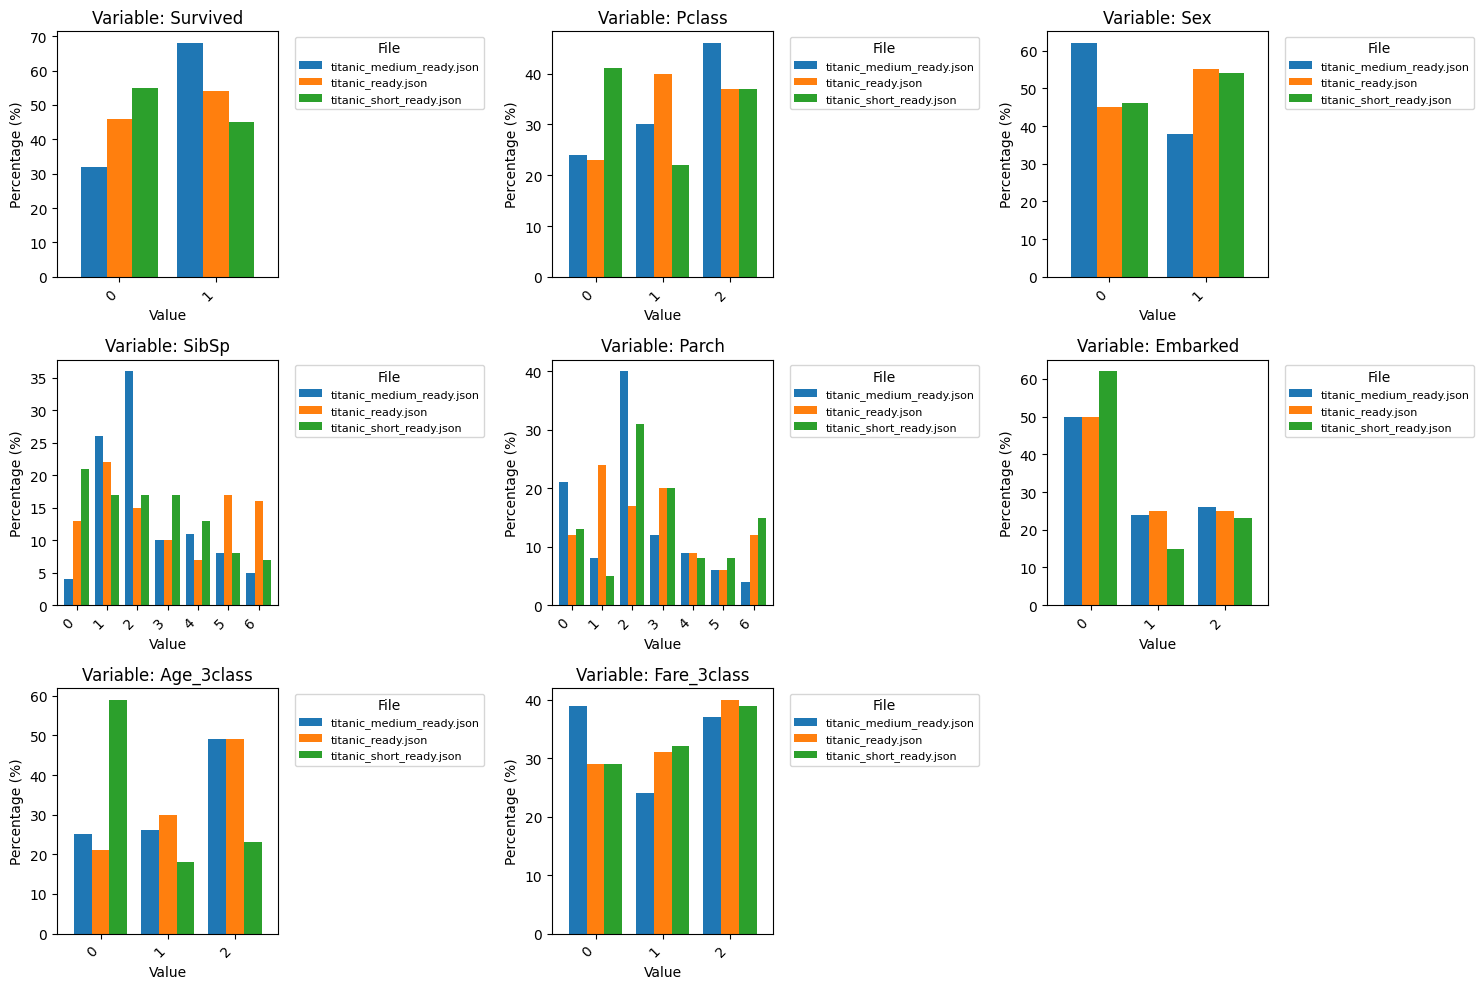

In [99]:
from new_sdscm_2 import(
    format_multiple_samples_as_dataframe,
    compare_variables_across_files,
    visualize_variable_comparison,
    create_summary_statistics,
    format_sequences_as_dataframe
)
variables = [
    "Survived",  # 2 sentences
    "Pclass",    # 3 sentences
    "Sex",       # 2 sentences
    "SibSp",     # 7 sentences
    "Parch",     # 7 sentences
    "Embarked",  # 3 sentences
    "Age_3class",# 3 sentences
    "Fare_3class"# 3 sentences
]
formatted_dfs = format_multiple_samples_as_dataframe(all_samples, format_sequences_as_dataframe, intervention_vars=["Sex"], outcome_vars=["Survived"])

# 3. 对比变量
comparison_df = compare_variables_across_files(formatted_dfs, variables)

# 4. 可视化
visualize_variable_comparison(comparison_df, variables)

# 5. 查看统计
summary_stats = create_summary_statistics(formatted_dfs, variables)

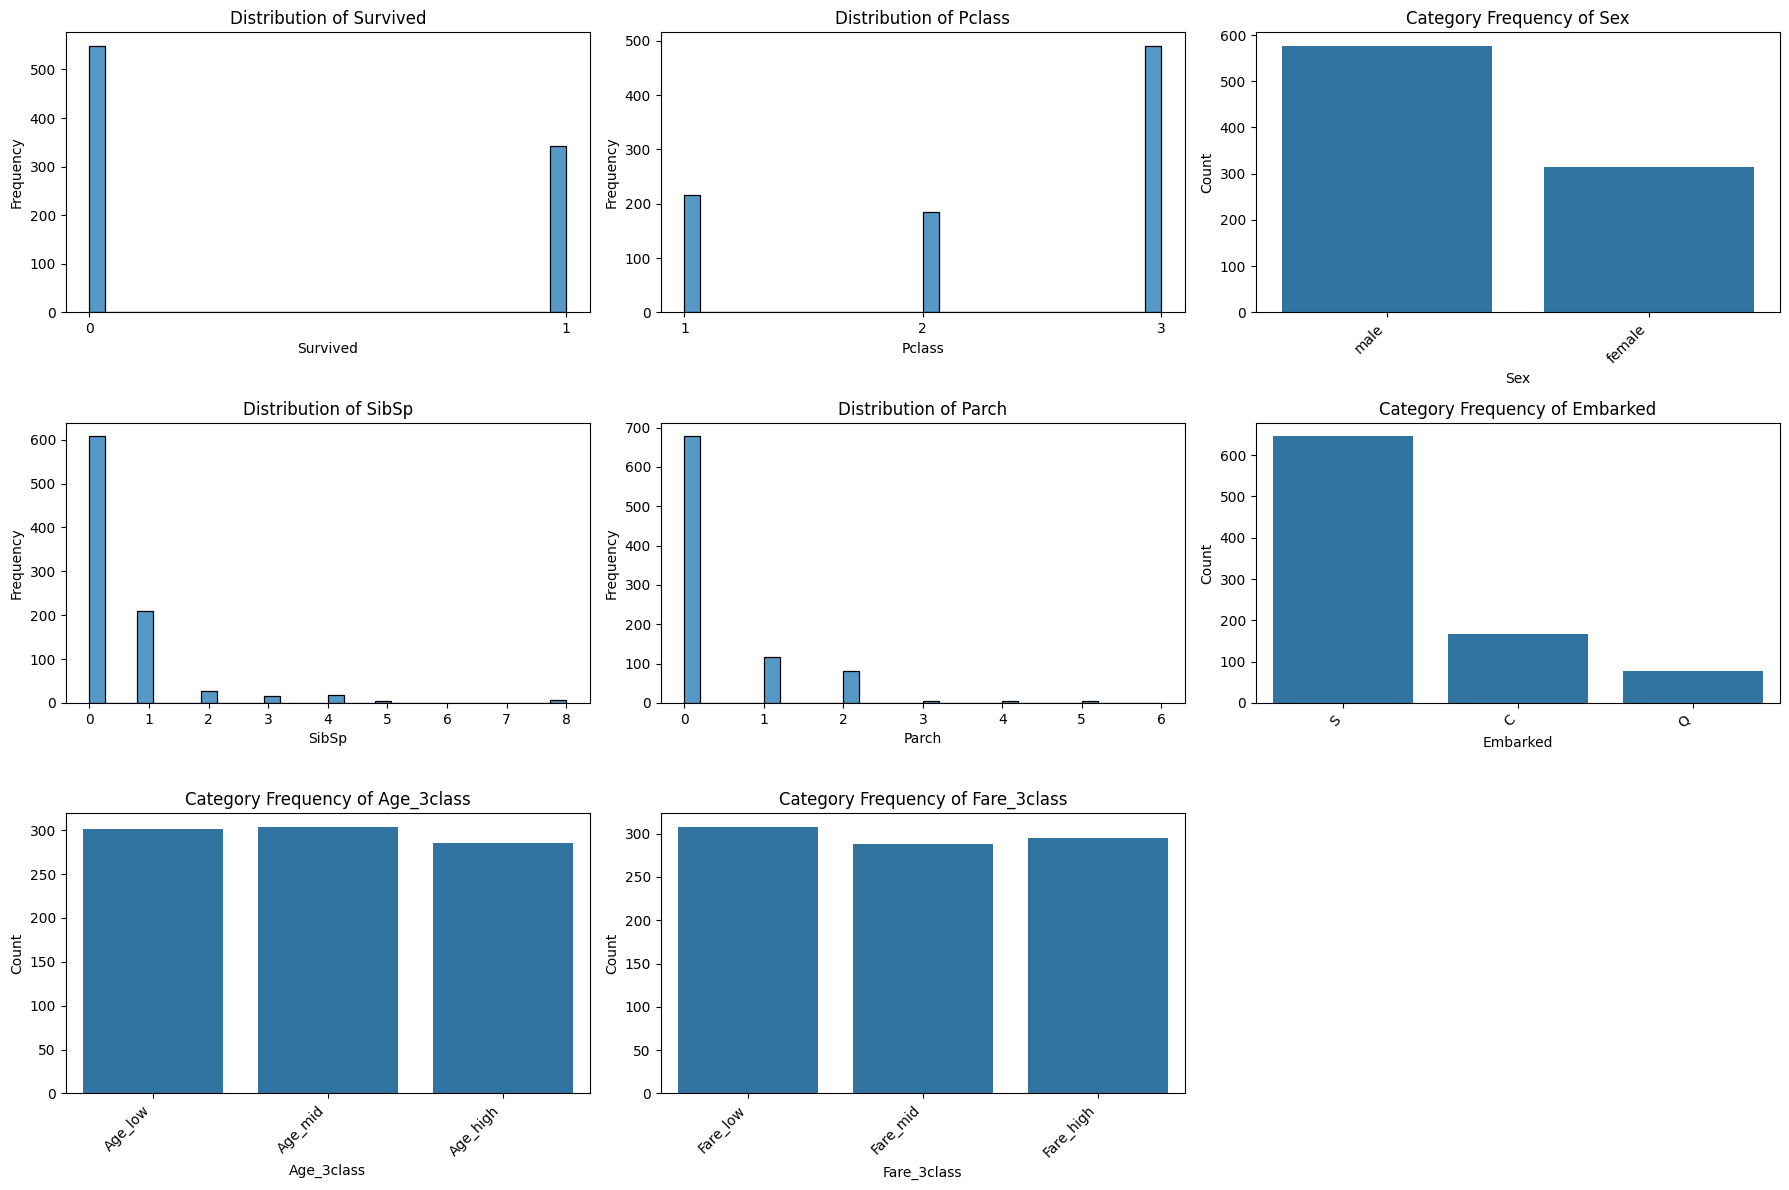

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_all_distributions(df, max_categories=20):
    n_cols = df.shape[1]
    n_rows = int(np.ceil(n_cols / 3))  
    plt.figure(figsize=(6 * 3, 4 * n_rows))

    for i, col in enumerate(df.columns, 1):
        plt.subplot(n_rows, 3, i)
        if pd.api.types.is_numeric_dtype(df[col]):
    
            sns.histplot(df[col].dropna(), bins=30, kde=False)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")

            min_val, max_val = df[col].min(), df[col].max()
            plt.xticks(np.arange(np.floor(min_val), np.ceil(max_val) + 1, 1))

        else:
            counts = df[col].value_counts().head(max_categories)
            sns.barplot(x=counts.index, y=counts.values)
            plt.title(f"Category Frequency of {col}")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

plot_all_distributions(new_df,8)